## [Exp-03]Kaggle Leaderboard

### 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

#### 1. 라이브러리 버전을 확인해 봅니다

In [1]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


1.6.1
3.3.2
0.5.1
1.1.1


#### 2. ✓ 튜닝해볼 수 있는 모델 클래스 인자

* lightgbm library parameter
    - max_depth : 의사 결정 나무의 깊이, 정수 사용
    - learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
    - n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
    - num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
    - boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

* [lightGBM / XGBoost 파라미터 설명](http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)  
해당 링크에서 별이 2~3개인 것들만 가져와봤습니다.
    -  early_stopping_round / early_stopping_rounds : 조기멈춤
    -  bagging_fraction / subsample : 행 샘플링, 과적합 제어용
    -  feature_fraction / colsample_bytree : 열 샘플링, 과적합 제어용
    -  scale_pos_weight : 샘플 스케일링
    -  Metric / Loss parameters

* [Chapter 4. 분류 - LightGBM](https://injo.tistory.com/48)
    - min_data_in_leaf / min_child_samples : 최종 리프 노드가 되기 위한 레코드수, 과적합 제어용
    - lambda_l2 / reg_lambda : L2 Regularization 적용 값, 피처 개수가 많을 때 적용을 검토, 클수록 과적합 감소 효과
    - lambda_l1 / reg_alpha : L1 Regularization 적용 값, 피처 개수가 많을 때 적용을 검토, 클수록 과적합 감소 
    - objective / objective : 'reg:linear':회귀, binary:logistic:이진분류, multi:softmax:다중분류, 클래스 반환, multi:softprob:다중분류, 확률반환

#### 3. ✓ 시도해볼 수 있는 방법

* 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
* LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
* 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
* Baseline 커널에서 활용했던 블렌딩 방법 활용하기

#### 프로젝트 시작

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

로컬에서 데이터를 불러옵니다.(Aiffel 자료 사용)

In [3]:
data_dir = os.getenv('HOME')+'/Code/Exploration Submit/3/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
train.shape

(15035, 21)

In [4]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [5]:
test.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

In [6]:
print(train.shape)
print(train.columns)
print(test.shape)
print(test.columns)

(15035, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
(6468, 20)
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### 데이터 분석

원활한 분석을 위해 먼저 string 으로 되어 있는 date column을 연/월/일만 쓰기위해 앞의 8자리만 가져오고 int값으로 바꿔줍니다.  
또 price 값을 log 취해줍니다.

In [7]:
print(type(train['date'][0]))
print(type(test['date'][0]))
train['date'] = train['date'].apply(lambda i: i[:8]).astype('int')
test['date'] = test['date'].apply(lambda i: i[:8]).astype('int')
print(type(train['date'][0]))
print(type(test['date'][0]))
print(train['date'][0])
print(test['date'][0])

train['price'] = np.log1p(train['price'])

<class 'str'>
<class 'str'>
<class 'numpy.int64'>
<class 'numpy.int64'>
20141013
20141209


train_test_split 함수와 기존 값에 exmp를 하여 RMSE 구하는 함수를 import 합니다.  
여러 모델을 import 합니다.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 사실 우리가 y 값을 log 했기 때문에 exp하고 MSE를 구해야한다.

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

columns들 중에서 어떤 것들이 price와 가장 관련있는지 확인해보기 위해  
상관분석을 해보겠습니다.  
pandas의 [pandas.DataFrame.corrwith](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html)를 참고했습니다.  
methods = ‘pearson’, ‘kendall’, ‘spearman’ 에 따라 높은 값을 가지는 값들을 그래프화 하였습니다.

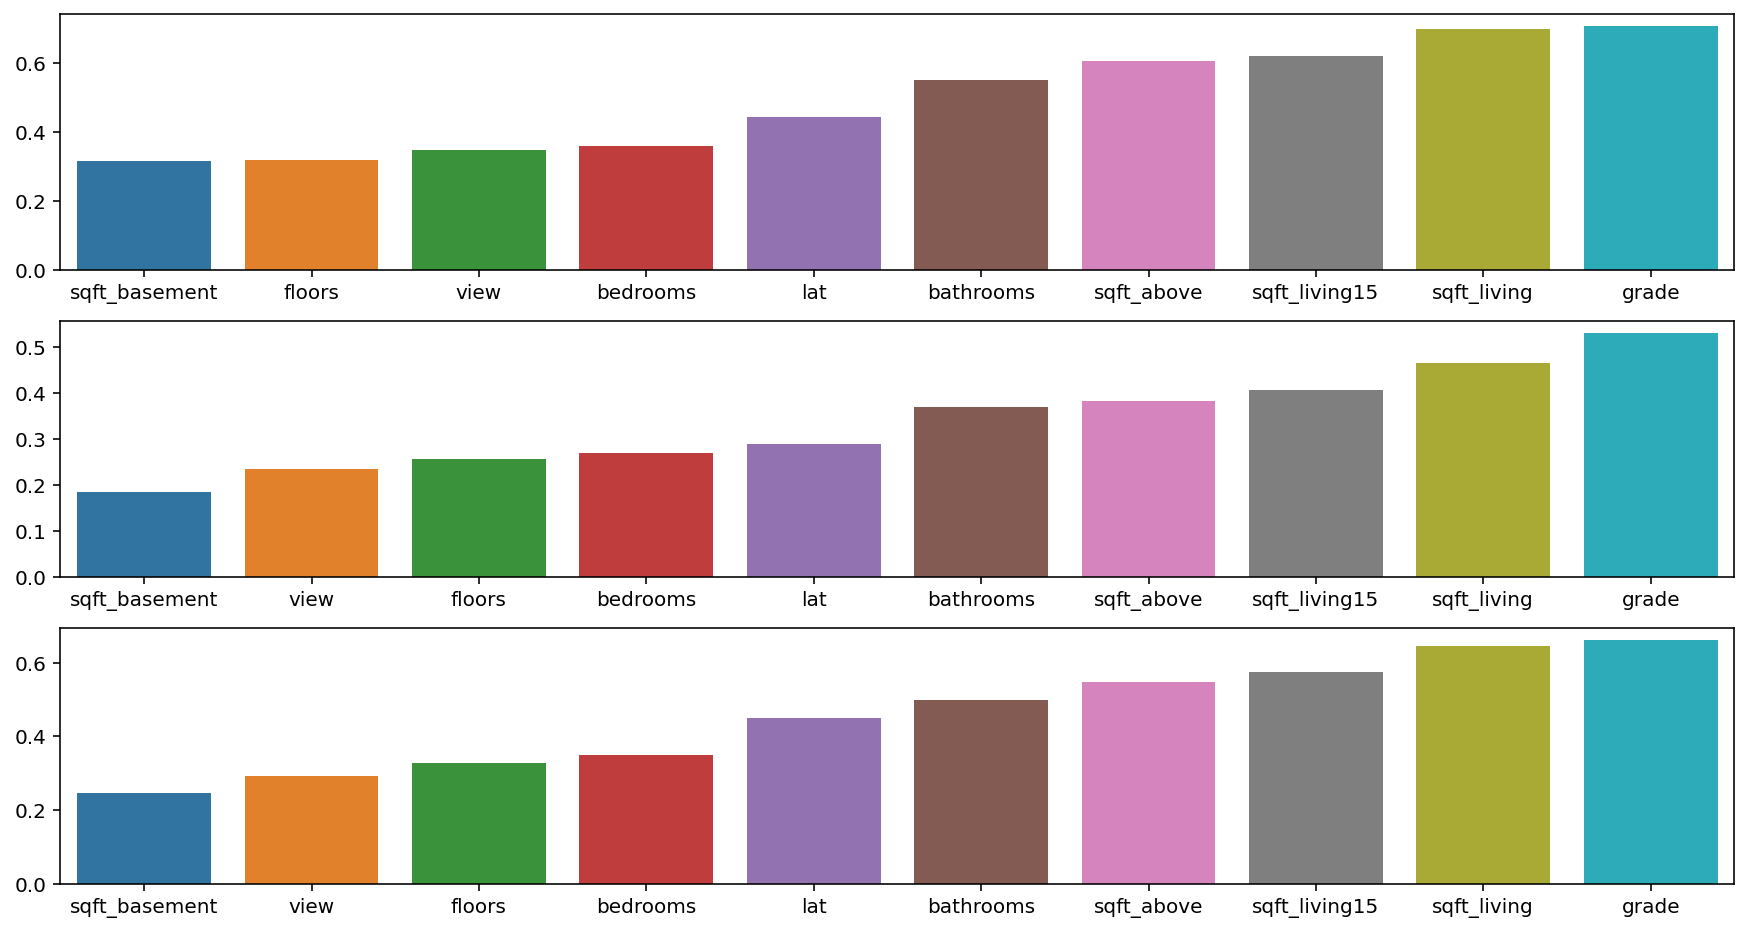

In [9]:
corr1 = train.corrwith(train['price'], method = 'pearson')
corr2 = train.corrwith(train['price'], method = 'kendall')
corr3 = train.corrwith(train['price'], method = 'spearman')

del corr1['price']
del corr2['price']
del corr3['price']
corr1 = corr1.sort_values()
corr2 = corr2.sort_values()
corr3 = corr3.sort_values()

corr1 = corr1[-10:]
corr2 = corr2[-10:]
corr3 = corr3[-10:]

fig, ax = plt.subplots(nrows = 3,figsize = (15,8))
sns.barplot(x=corr1.index, y=corr1.values, ax = ax[0])
sns.barplot(x=corr2.index, y=corr2.values, ax = ax[1])
sns.barplot(x=corr3.index, y=corr3.values, ax = ax[2])

plt.show()


grade, sqft_living, sqft_living15, sqft_above, bathfrooms, lat, bedrooms, view or floors 순으로 큰 관계를 가지는 것을 알 수 있습니다.  
해당 지표들과 price의 관계를 보면서 이상치나 결측치를 제거해보겠습니다.

#### 데이터 전처리

##### 결측치 및 이상치 제거

먼저 결측치 및 이상치 제거부터 해보겠습니다.  
결측치는 이미 practice 에서 없다는 것을 알고 있으니 이상치만 제거해주면 될 것 같습니다.
위 상관 지표들 중 가장 높았던 grade 를 먼저 살펴보겠습니다.  
[그래프 작성 시 참고](https://dining-developer.tistory.com/30)

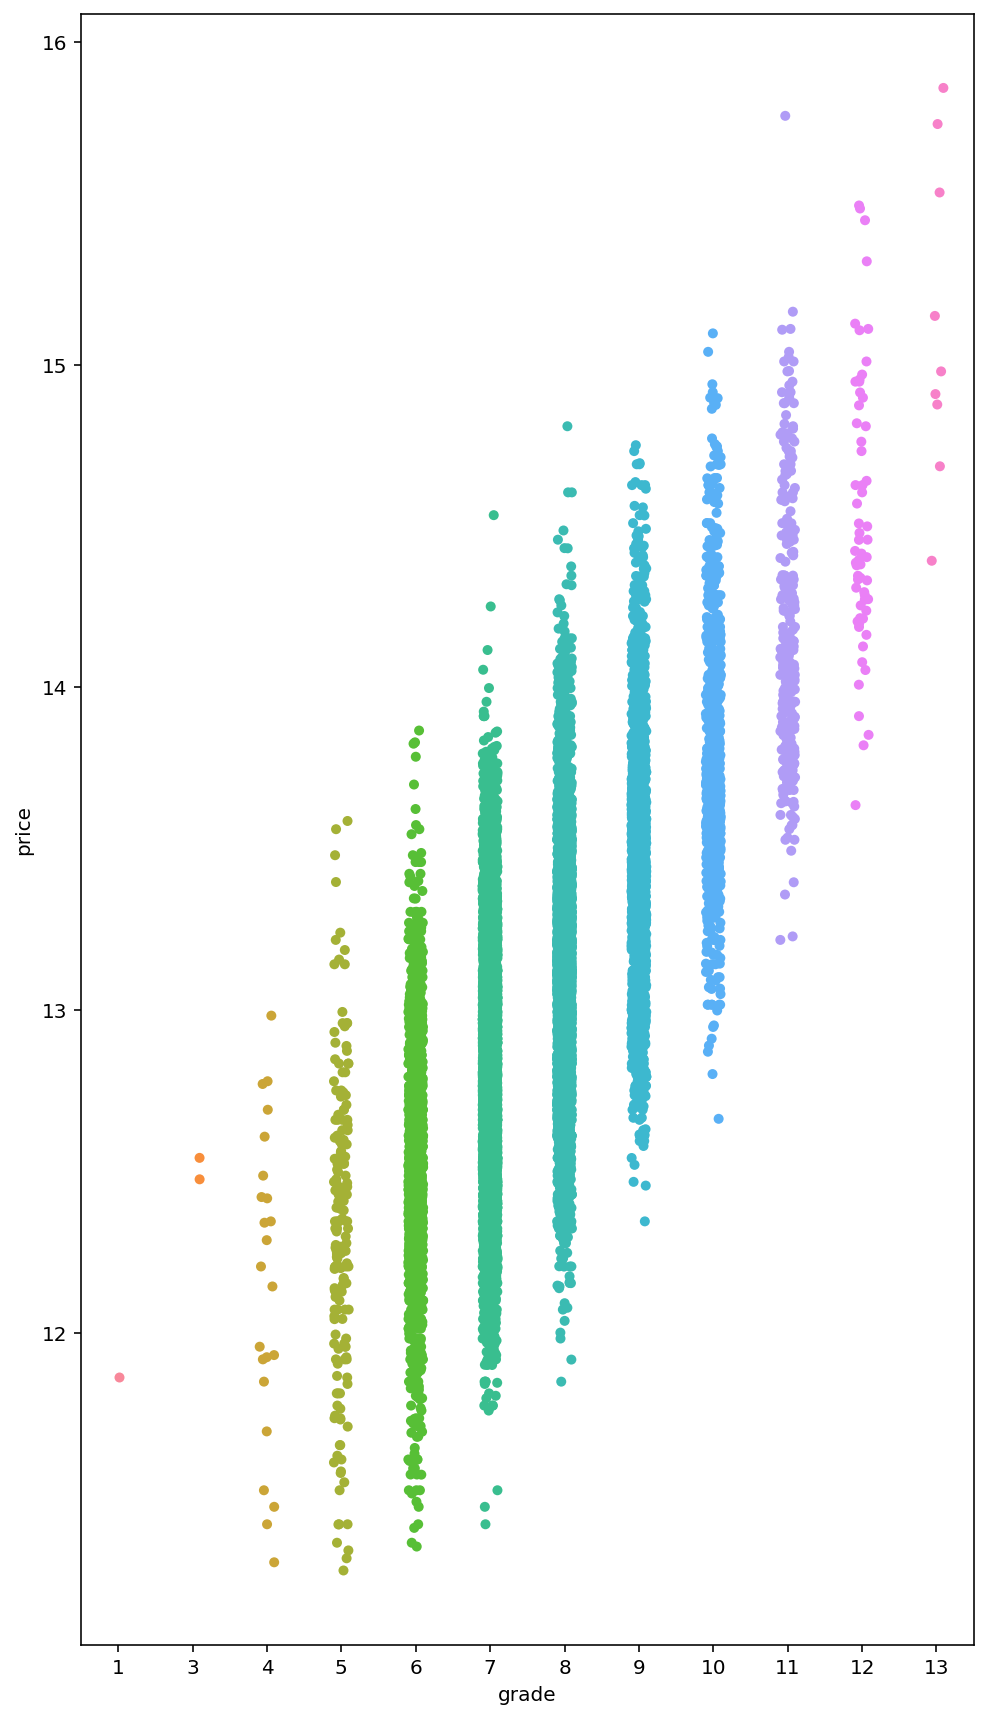

In [10]:
fig, ax = plt.subplots(figsize=(8, 15))
fig = sns.stripplot(x=train['grade'], y=train['price'])
plt.show()

그래프에서 보면 grade 1,3의 값들은 좀 동떨어져보이고  
grade 7에서 14.3 이상, 11.6 이하  
grade 8에서 14.7 이상  
grade 11에서 15.5 이상의 값들이 이상해보입니다.

In [11]:
train.loc[(train['grade'] == 1) | (train['grade'] == 3)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
2302    2302  20150225  12.476104         1       0.75          520     12981   
4123    4123  20141104  12.542548         1       0.00          600     24501   
13522  13522  20140926  11.863589         0       0.00          290     20875   

       floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
2302      1.0           0     0  ...      3         520              0   
4123      1.0           0     0  ...      3         600              0   
13522     1.0           0     0  ...      1         290              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
2302       1920             0    98022  47.2082 -121.995           1340   
4123       1950             0    98045  47.5316 -121.749            990   
13522      1963             0    98024  47.5308 -121.888           1620   

       sqft_lot15  
2302        12233  
4123        22549  
13522       22850  

[3 rows x 21 columns]

In [12]:
train.loc[((train['price']>(14.3)) | (train['price']<(11.6)))& (train['grade'] == 7)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
878      878  20140717  11.512935         2       1.00          770     17334   
2372    2372  20141212  11.461643         2       1.00          800      8550   
8756    8756  20140513  11.407576         2       1.00          790      2640   
12346  12346  20150115  14.533351         4       3.25         3580     19989   

       floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
878       1.0           0     0  ...      7         770              0   
2372      1.0           0     0  ...      7         800              0   
8756      1.0           0     0  ...      7         790              0   
12346     1.5           1     4  ...      7        3480            100   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
878        1978             0    98001  47.2997 -122.269           1480   
2372       1947             0    98198  47.4075 -122.294           1490   
8756       1973             0    98034  47.7351 -122.178           1310   
12346      1915          1965    98125  47.7087 -122.276           2410   

       sqft_lot15  
878         17334  
2372         8550  
8756         2064  
12346        6389  

[4 rows x 21 columns]

In [13]:
train.loc[(train['price']>14.7) & (train['grade'] == 8)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
7173  7173  20140813  14.808763         5        4.0         4230     27295   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
7173     2.0           1     4  ...      8        3230           1000   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
7173      1949          1985    98033  47.6803 -122.214           2660   

      sqft_lot15  
7173       27295  

[1 rows x 21 columns]

In [14]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

id      date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
2775  2775  20140611  15.77031         5        4.5        10040     37325   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
2775     2.0           1     2  ...     11        7680           2360   

      yr_built  yr_renovated  zipcode    lat     long  sqft_living15  \
2775      1940          2001    98004  47.65 -122.214           3930   

      sqft_lot15  
2775       25449  

[1 rows x 21 columns]

2302, 4123, 13522, 878, 2372, 8756, 12346, 7173, 2775  
이제 해당 값들을 삭제 해줍니다.

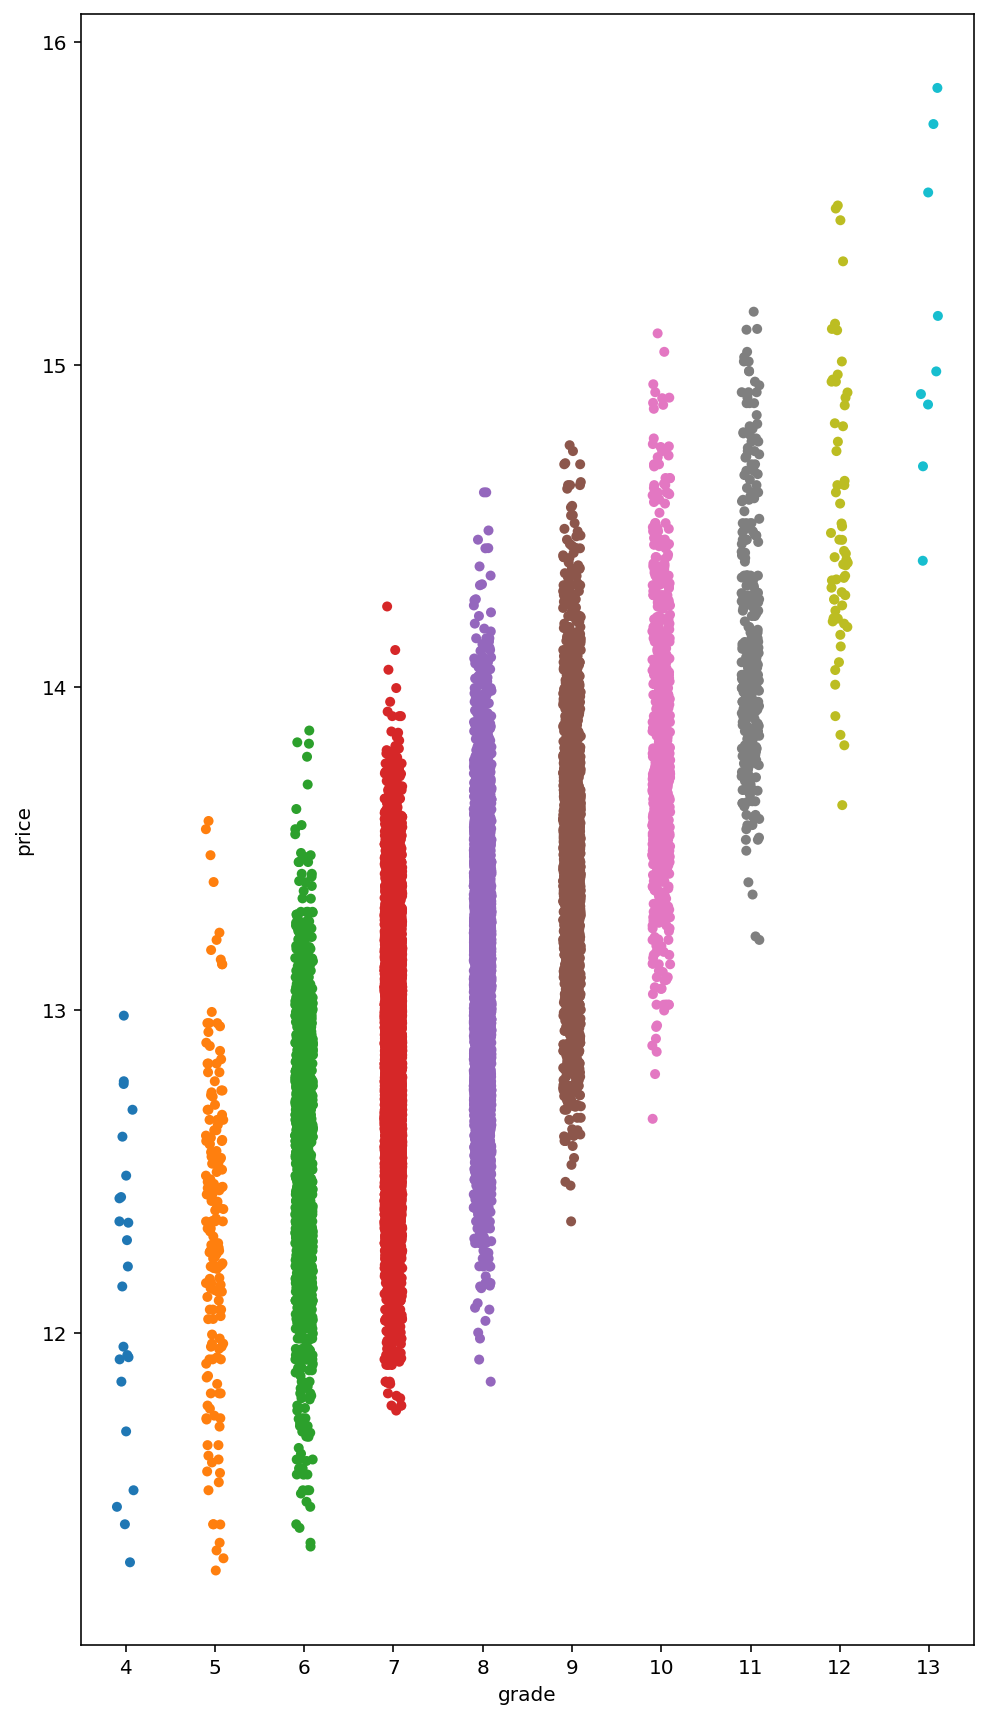

In [15]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=13522]
train = train.loc[train['id']!=878]
train = train.loc[train['id']!=2372]
train = train.loc[train['id']!=8756]
train = train.loc[train['id']!=12346]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]

fig, ax = plt.subplots(figsize=(8, 15))
fig = sns.stripplot(x=train['grade'], y=train['price'])
plt.show()

Grade에 따른 이상치가 제거 되었습니다.  
상관성이 다음으로 높았던 지표인 sqrt_living 을 보겠습니다.

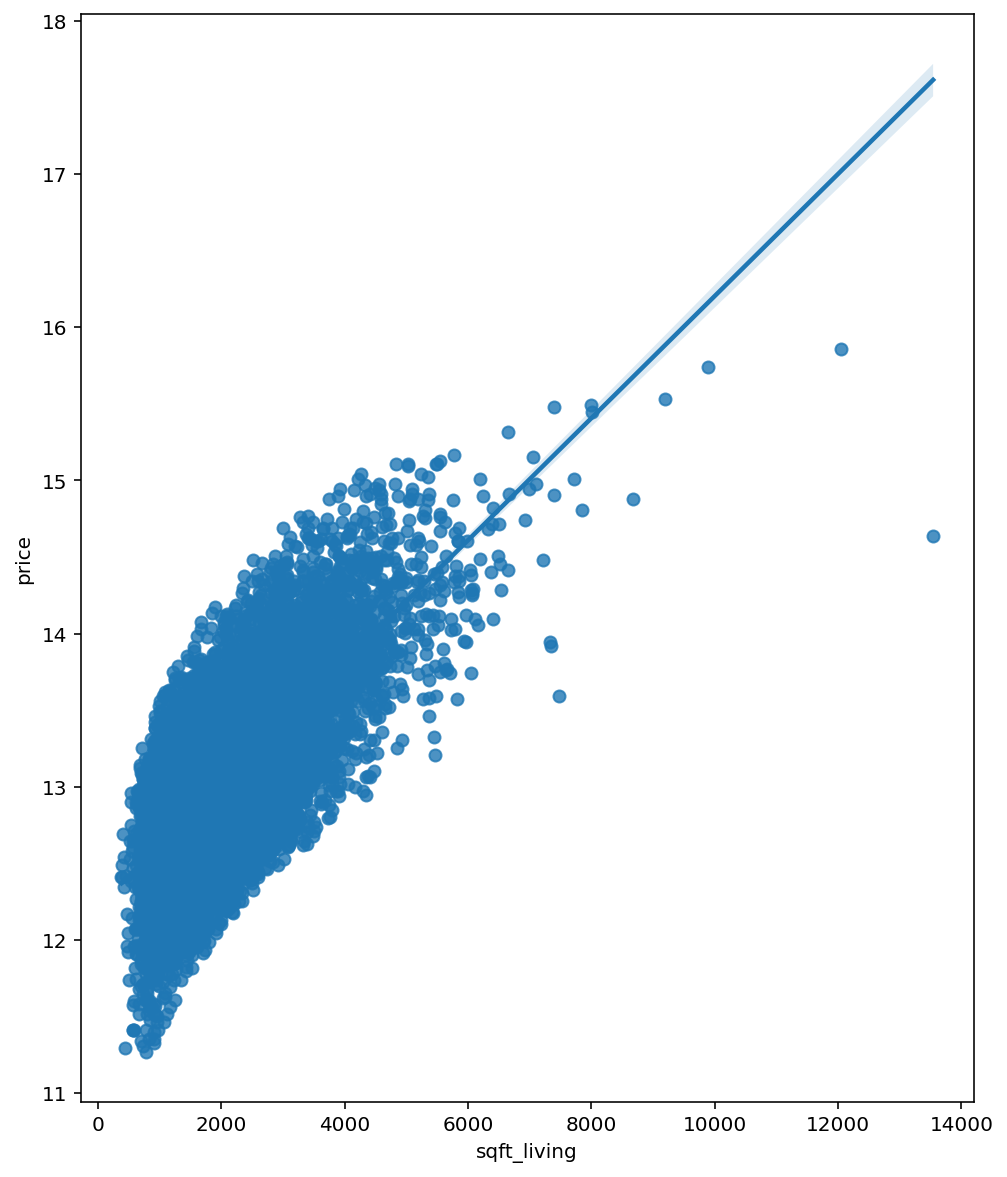

In [16]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.regplot(x=train['sqft_living'], y=train["price"])
plt.show()

sqft_living이 7000~800, price가 13.6이하인 경우와  
sqft_living이 12000 이상인 경우에 이상치 인것 같습니다.

In [17]:
train.loc[(train['price'] < 13.6) & (train['sqft_living'] > 7000)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
2859  2859  20141007  13.592368         7       6.75         7480     41664   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
2859     2.0           0     2  ...     11        5080           2400   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
2859      1953             0    98166  47.4643 -122.368           2810   

      sqft_lot15  
2859       33190  

[1 rows x 21 columns]

In [18]:
train.loc[(train['sqft_living'] > 12000)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
5108  5108  20141013  15.856731         6        8.0        12050     27600   
8912  8912  20140505  14.639686         7        8.0        13540    307752   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
5108     2.5           0     3  ...     13        8570           3480   
8912     3.0           0     4  ...     12        9410           4130   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
5108      1910          1987    98102  47.6298 -122.323           3940   
8912      1999             0    98053  47.6675 -121.986           4850   

      sqft_lot15  
5108        8800  
8912      217800  

[2 rows x 21 columns]

2859, 5108, 8912  
3개를 이상치로 보고 제거합니다.

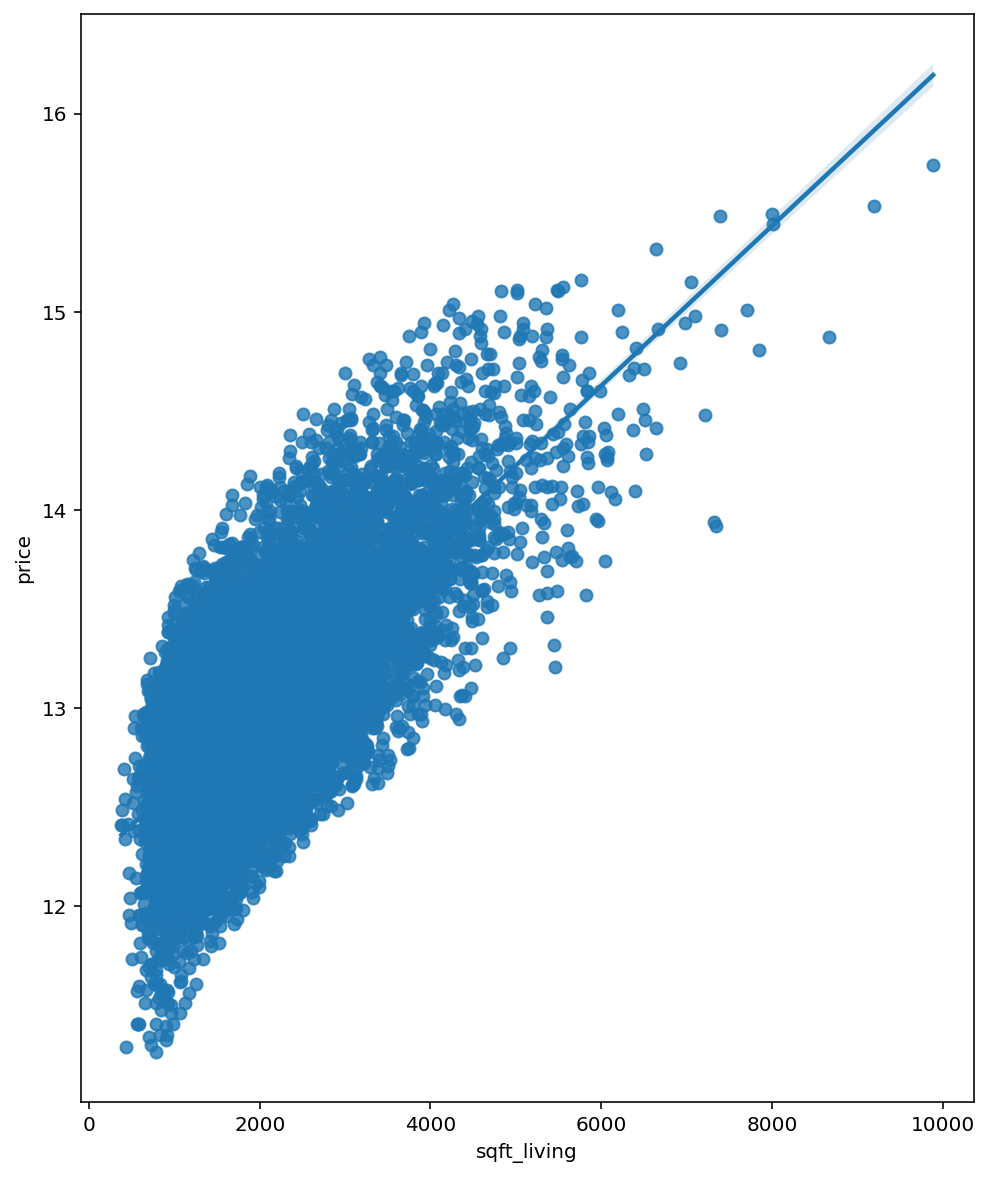

In [19]:
train = train.loc[train['id']!=2859]
train = train.loc[train['id']!=5108]
train = train.loc[train['id']!=8912]
fig, ax = plt.subplots(figsize=(8, 10))
sns.regplot(x=train['sqft_living'], y=train["price"])
plt.show()

그 다음으로 중요한 sqft_living15을 알아보겠습니다.

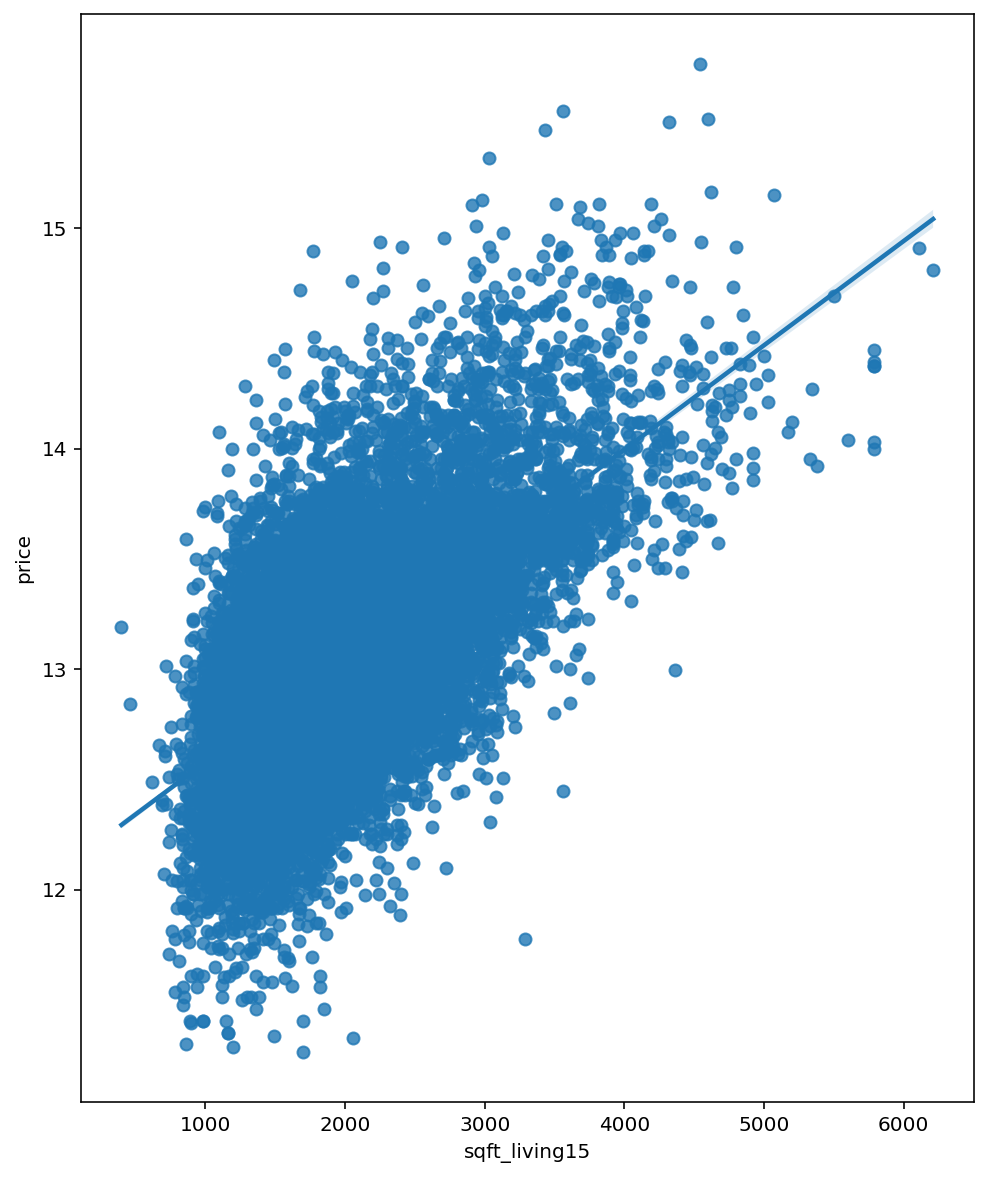

In [20]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.regplot(x=train['sqft_living15'], y=train["price"])
plt.show()

sqft_living15가 3000 ~ 4000에서 price가 12보다 작은 1개의 값이 이상치 같습니다.  
제거해줍니다.

In [21]:
train.loc[(train['price'] < 12) & (train['sqft_living15'] > 3000)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
12748  12748  20140924  11.775297         3        1.0         1200      7000   

       floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
12748     2.0           0     0  ...      7        1200              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
12748      1908             0    98116  47.5883 -122.384           3290   

       sqft_lot15  
12748        6000  

[1 rows x 21 columns]

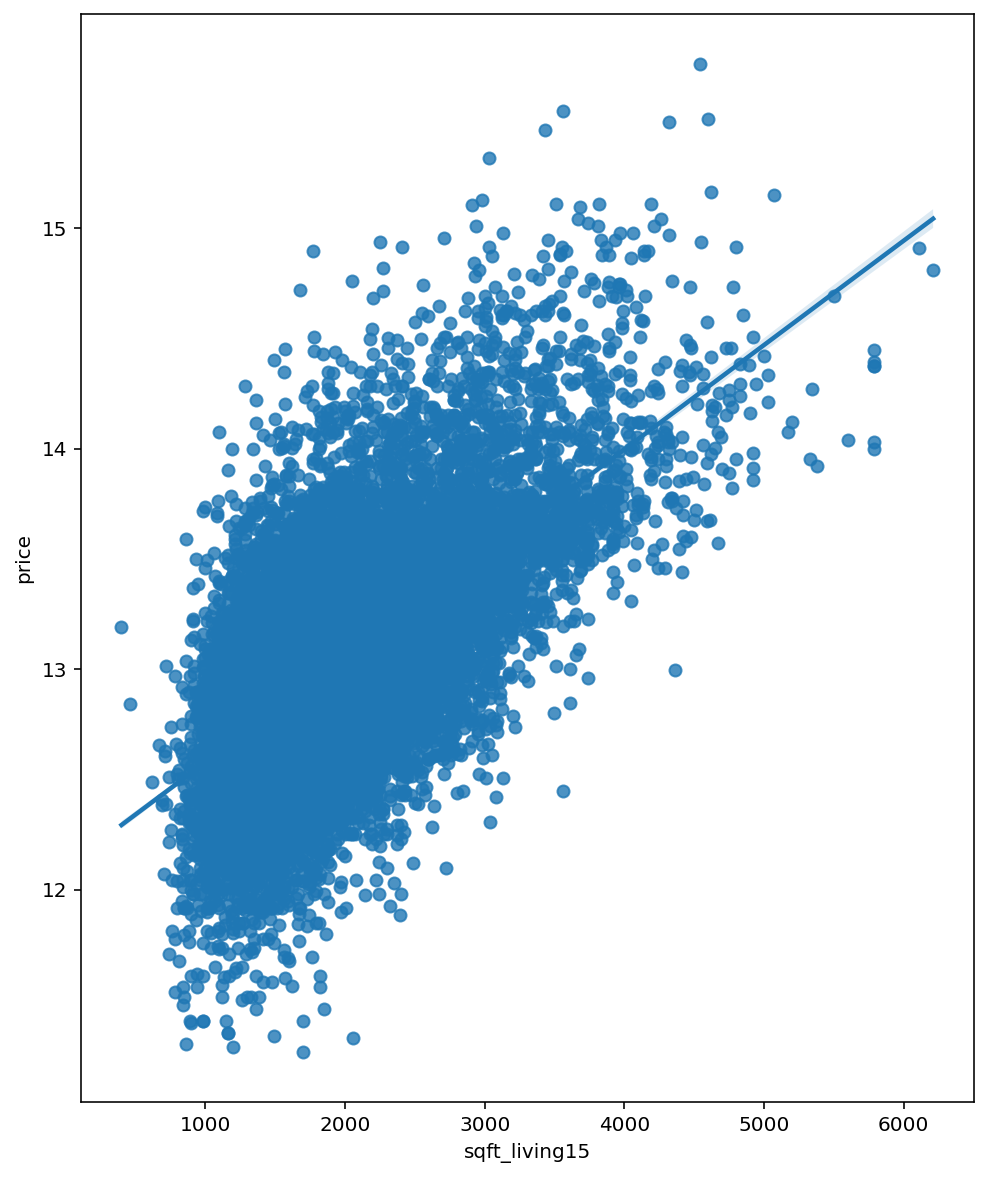

In [22]:
train = train.loc[train['id']!=12748]
fig, ax = plt.subplots(figsize=(8, 10))
sns.regplot(x=train['sqft_living15'], y=train["price"])
plt.show()

다음으로 중요한 지표인 sqrt_above를 알아보겠습니다.

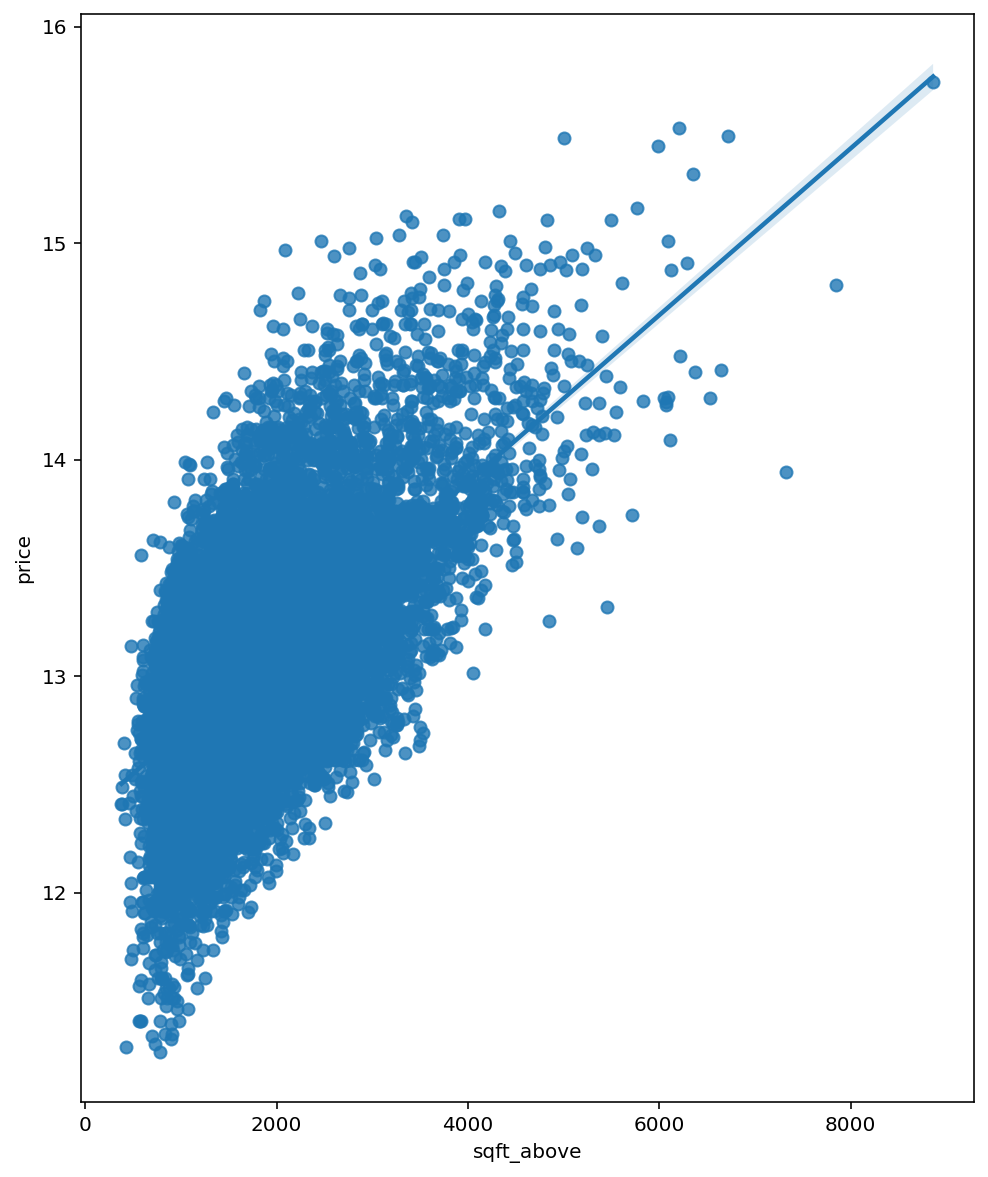

In [23]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.regplot(x=train['sqft_above'], y=train["price"])
plt.show()

sqft_above가 7000이상 price가 14이하 인 곳이 이상치 같습니다.  
제거해주겠습니다.

In [24]:
train.loc[(train['price'] < 14) & (train['sqft_above'] > 7000)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
12921  12921  20140708  13.942364         5        4.0         7320    217800   

       floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
12921     2.0           0     0  ...     11        7320              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
12921      1992             0    98058  47.4473 -122.086           3270   

       sqft_lot15  
12921       34500  

[1 rows x 21 columns]

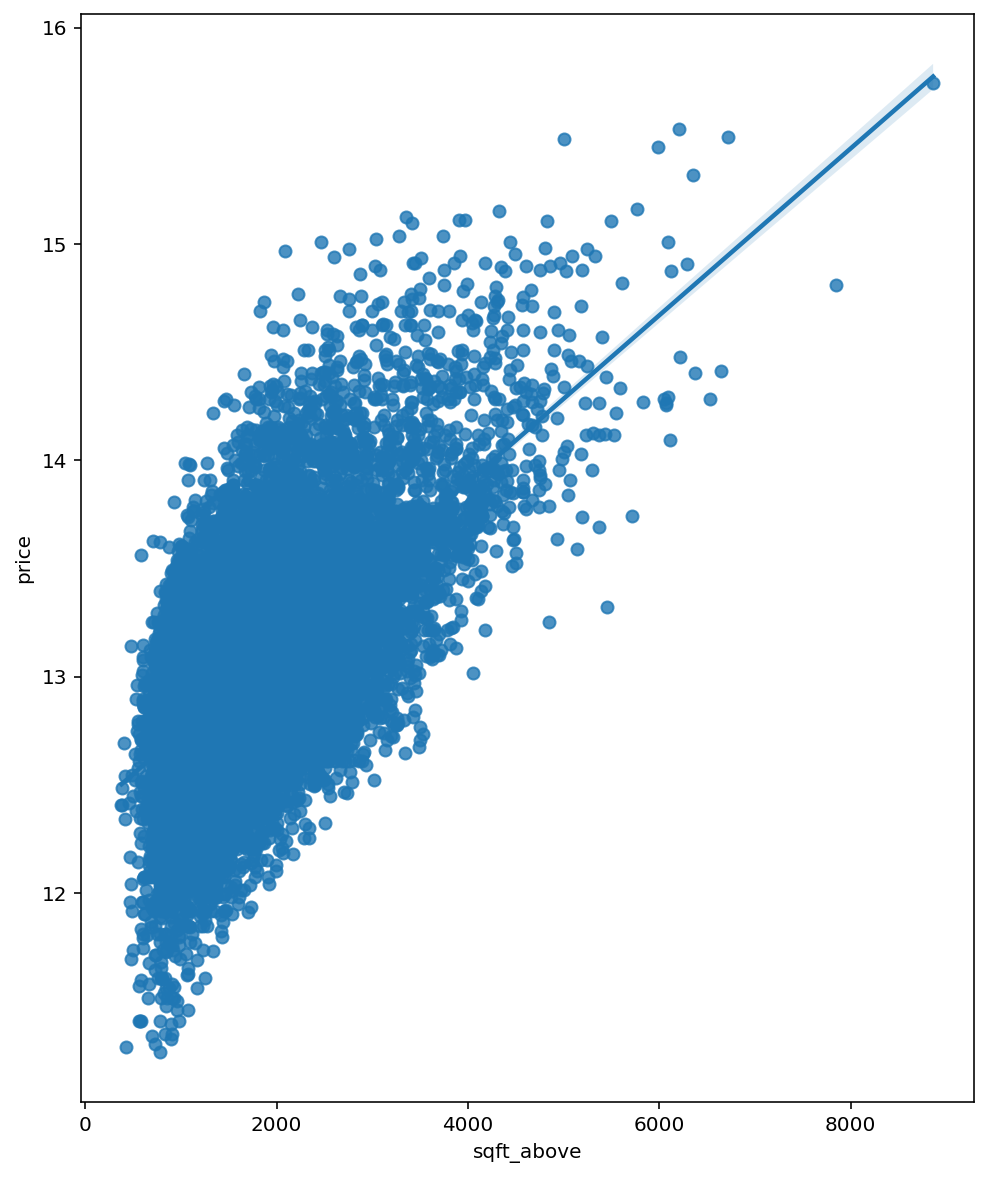

In [25]:
train = train.loc[train['id']!=12921]
fig, ax = plt.subplots(figsize=(8, 10))
sns.regplot(x=train['sqft_above'], y=train["price"])
plt.show()

다음 지표는 bathroom 입니다.

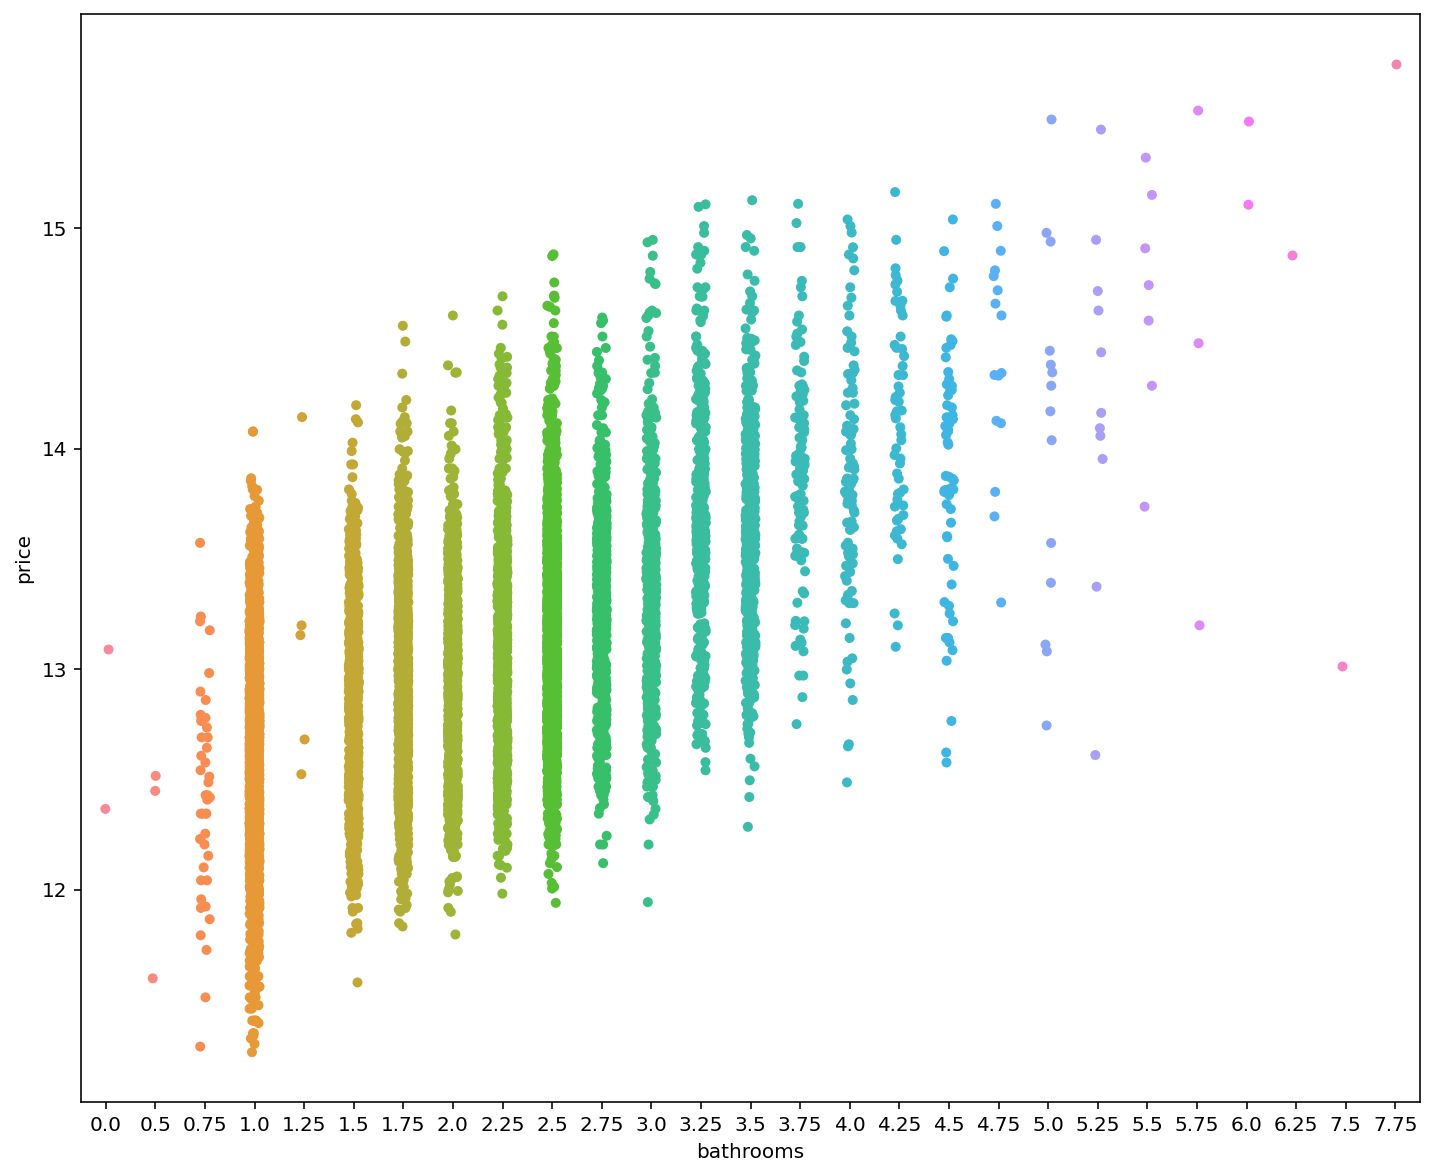

In [26]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.stripplot(x=train['bathrooms'], y=train["price"])
plt.show()

bathrooms가 6.25이상, price가 13.2보다 낮은 경우가 이상치 같습니다.  
제거하겠습니다.

In [27]:
train.loc[(train['price'] < 13.2) & (train['bathrooms'] > 6.25)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
5990  5990  20140811  13.017005         9        7.5         4050      6504   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
5990     2.0           0     0  ...      7        4050              0   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
5990      1996             0    98144  47.5923 -122.301           1448   

      sqft_lot15  
5990        3866  

[1 rows x 21 columns]

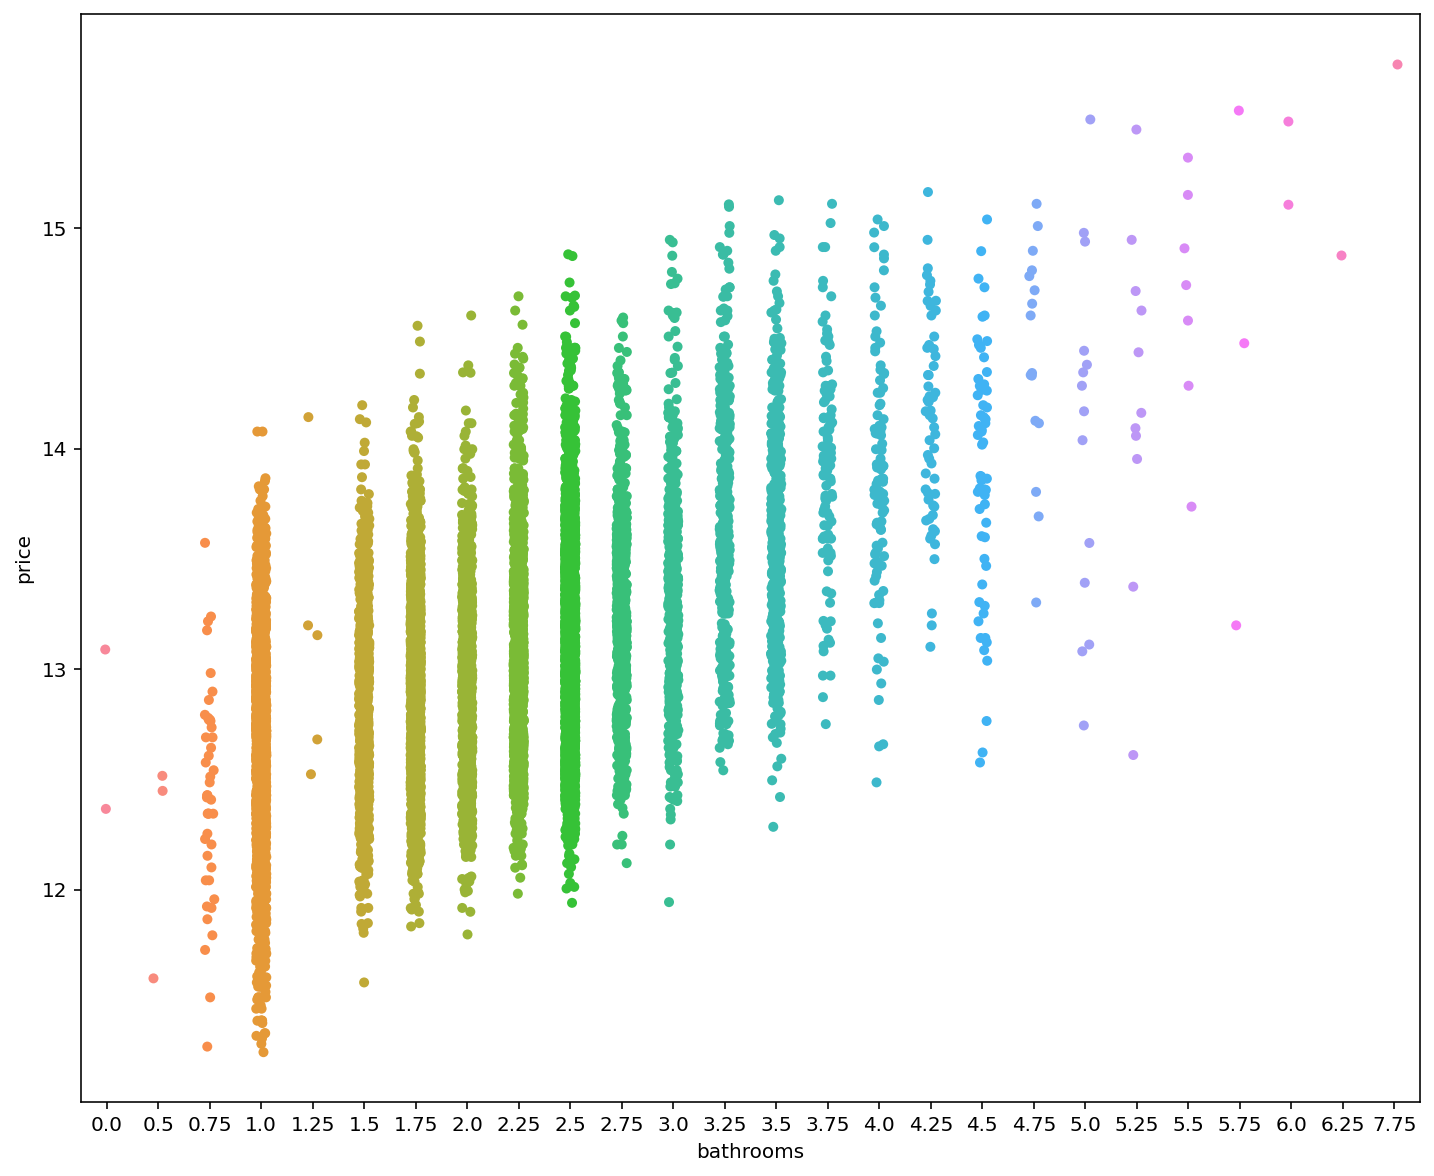

In [28]:
train = train.loc[train['id']!=5990]
fig, ax = plt.subplots(figsize=(12, 10))
sns.stripplot(x=train['bathrooms'], y=train["price"])
plt.show()

그 다음은 lat 입니다.

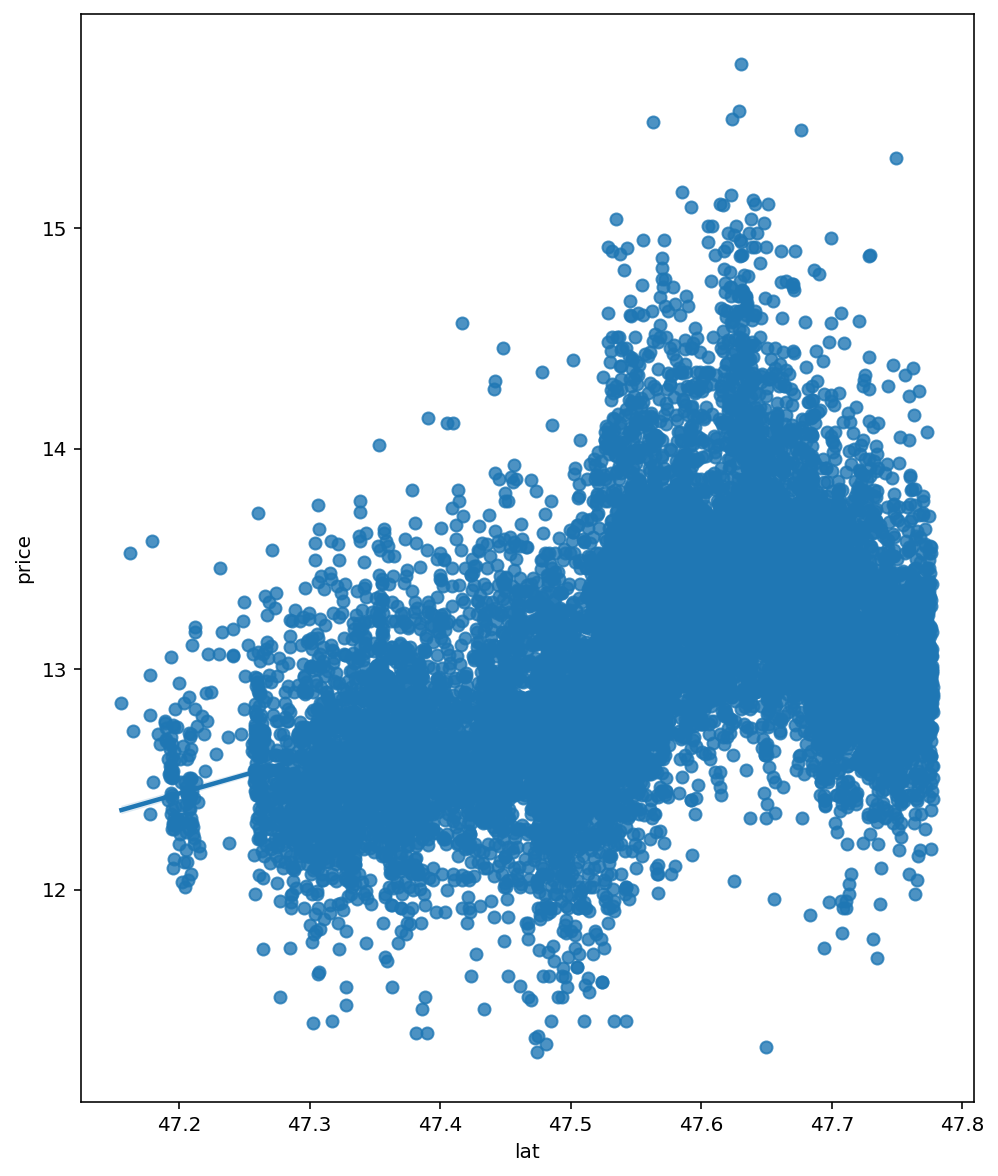

In [29]:
fig, ax = plt.subplots(figsize=(8, 10))
fig = sns.regplot(x=train['lat'], y=train['price'])

lat는 무엇이길래 이렇게 나올까요? 찾아보니 위도입니다.  
위도가 변함에 따라 집값이 차이가 나는 거 같습니다. 정확한 관계 분석이 안되서 확실한 이상치를 찾기가 애매하군요.  
그나마 47.6과 47.7 사이고 11.5보다 낮은 곳이 확실히 다른 값들과 떨어져 있습니다.  
찾아보고 제거합니다.

In [30]:
train.loc[(train['price']< 11.5) & (train['lat'] > 47.6)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
339  339  20140523  11.289794         1       0.75          430      5050   

     floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
339     1.0           0     0  ...      4         430              0   

     yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
339      1912             0    98014  47.6499 -121.909           1200   

     sqft_lot15  
339        7500  

[1 rows x 21 columns]

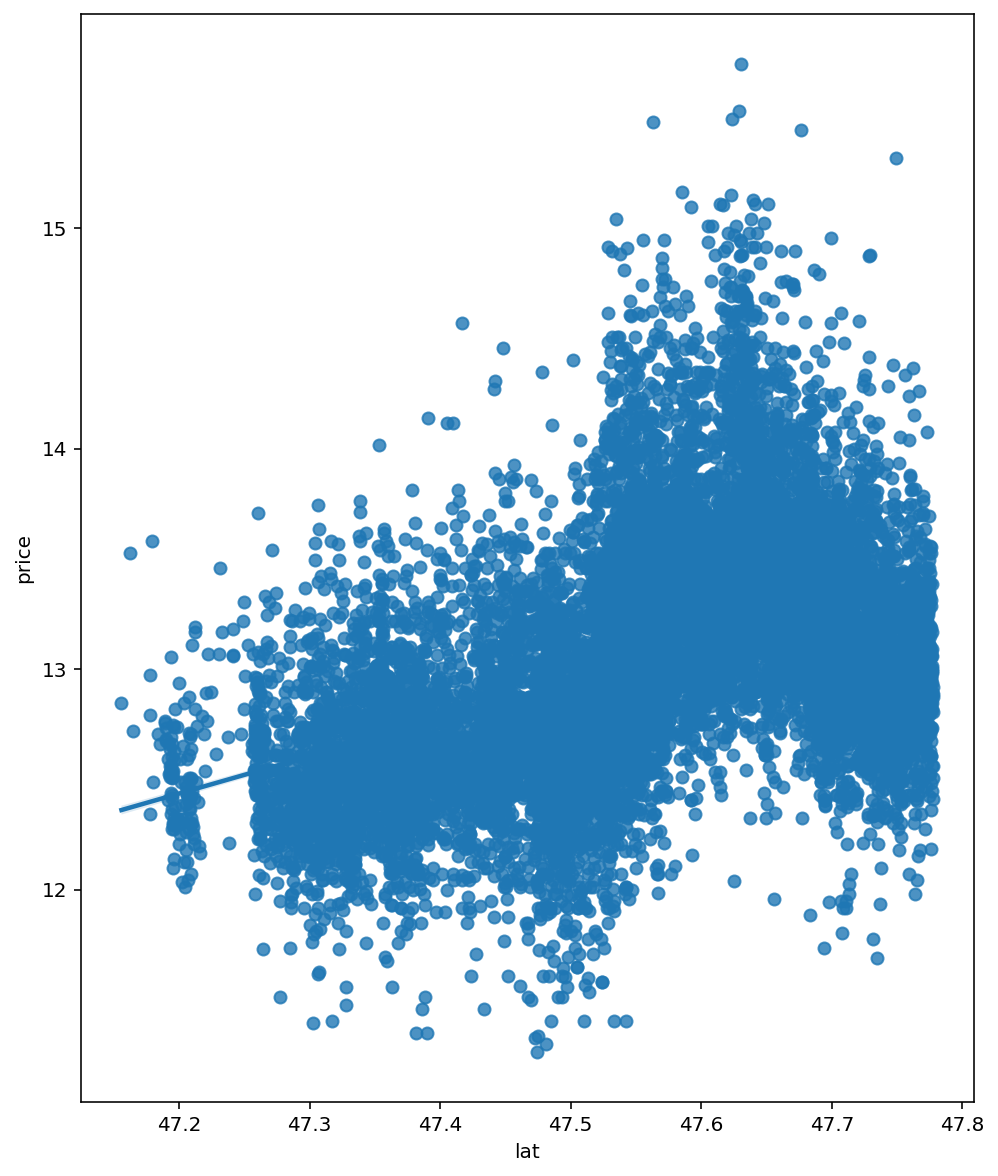

In [31]:
train = train.loc[train['id']!=339]
fig, ax = plt.subplots(figsize=(8, 10))
fig = sns.regplot(x=train['lat'], y=train['price'])

제대로 제거된 것 같습니다.  
다음 지표는 bedrooms입니다. 침실의 수를 나타내는 지표군요.    
일단 그래프로 그려보죠.

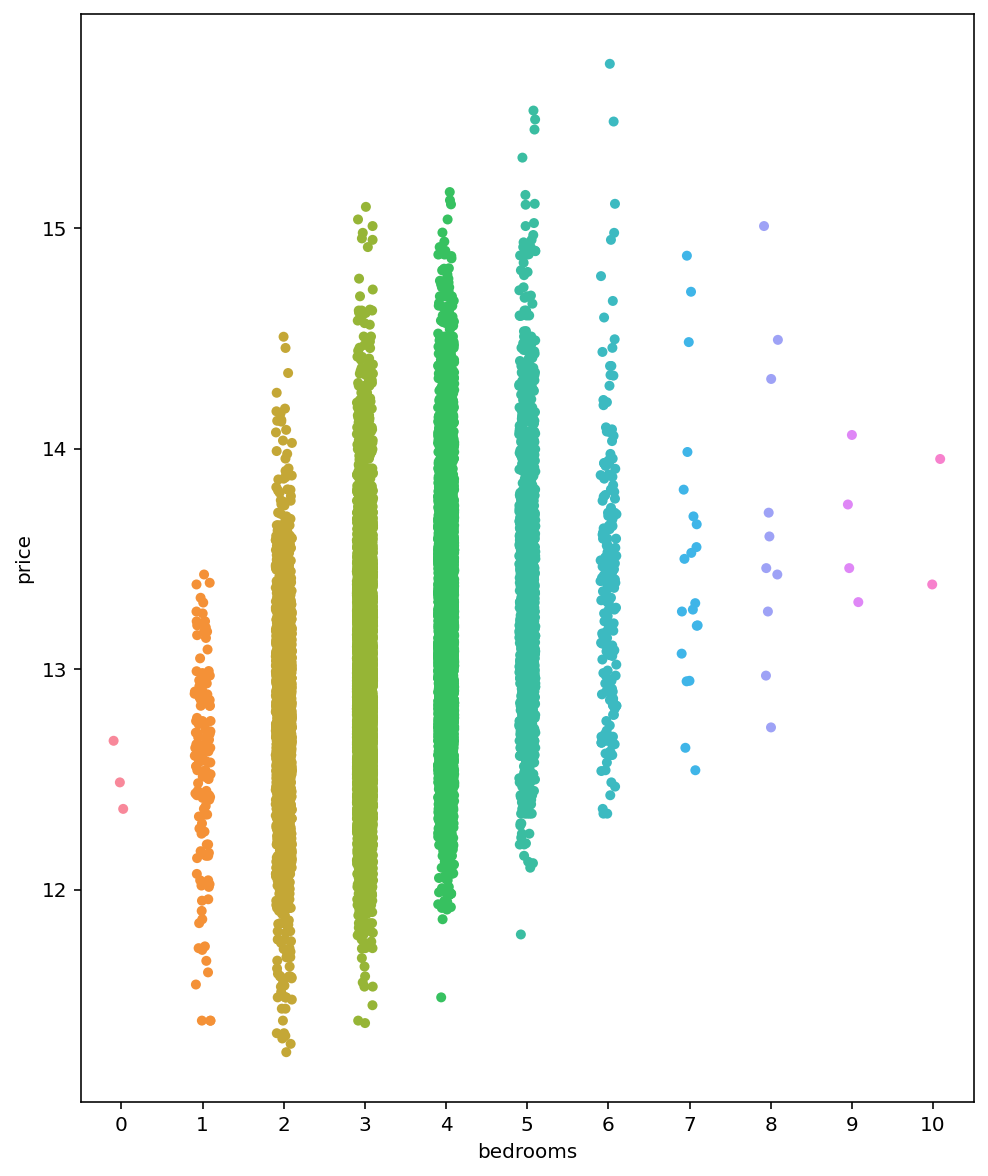

In [32]:
fig, ax = plt.subplots(figsize=(8, 10))
fig = sns.stripplot(x=train['bedrooms'], y=train['price'])
plt.show()

bedrooms = 10 일 때 price가 13.5보다 작은 경우가 이상치 같습니다.

In [33]:
train.loc[(train['price'] < 13.5) & (train['bedrooms'] == 10)]

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
10575  10575  20141029  13.384729        10        2.0         3610     11914   

       floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
10575     2.0           0     0  ...      7        3010            600   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
10575      1958             0    98006  47.5705 -122.175           2040   

       sqft_lot15  
10575       11914  

[1 rows x 21 columns]

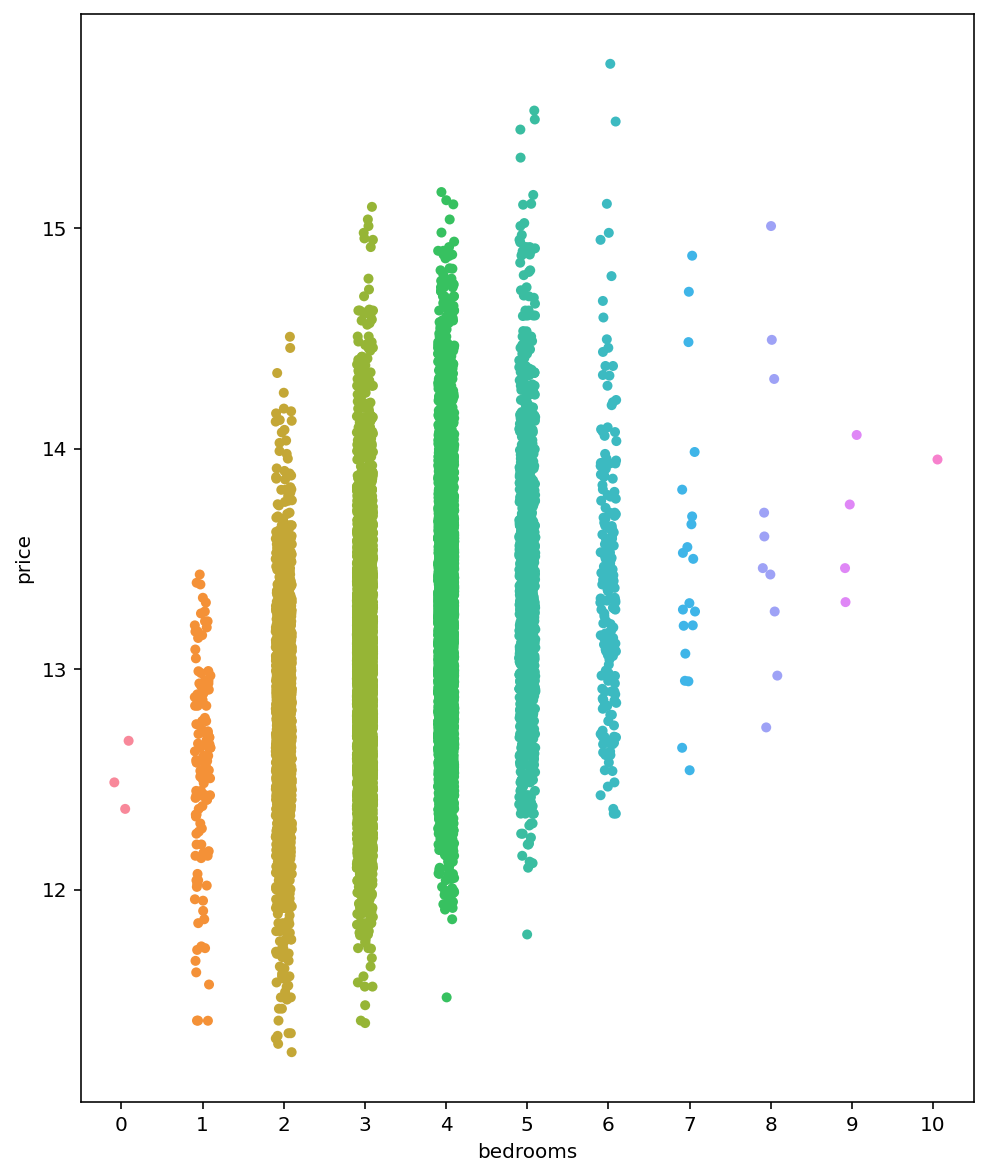

In [34]:
train = train.loc[train['id']!=10575]
fig, ax = plt.subplots(figsize=(8, 10))
fig = sns.stripplot(x=train['bedrooms'], y=train['price'])
plt.show()

이제 왠만한 이상치는 제거해준것 같습니다.  
[링크](https://www.kaggle.com/code/kcs93023/2019-ml-month-2nd-baseline/notebook)를 참고해서 각 지표들의 분포를 확인해봅시다.  
분포를 확인하기 전에 train의 지표를 적절하게 바꿔줍니다.  
test도 함께 바꿔줍니다.  
(위의 new_train_copy 에 적용된 것을 train, test에 적용합니다.)

In [35]:
y = train['price']
# 이미 y(price)는 로그화 된 상태입니다.
train = train.drop(['id','price'], axis = 1)
test = test.drop(['id'],axis = 1)
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

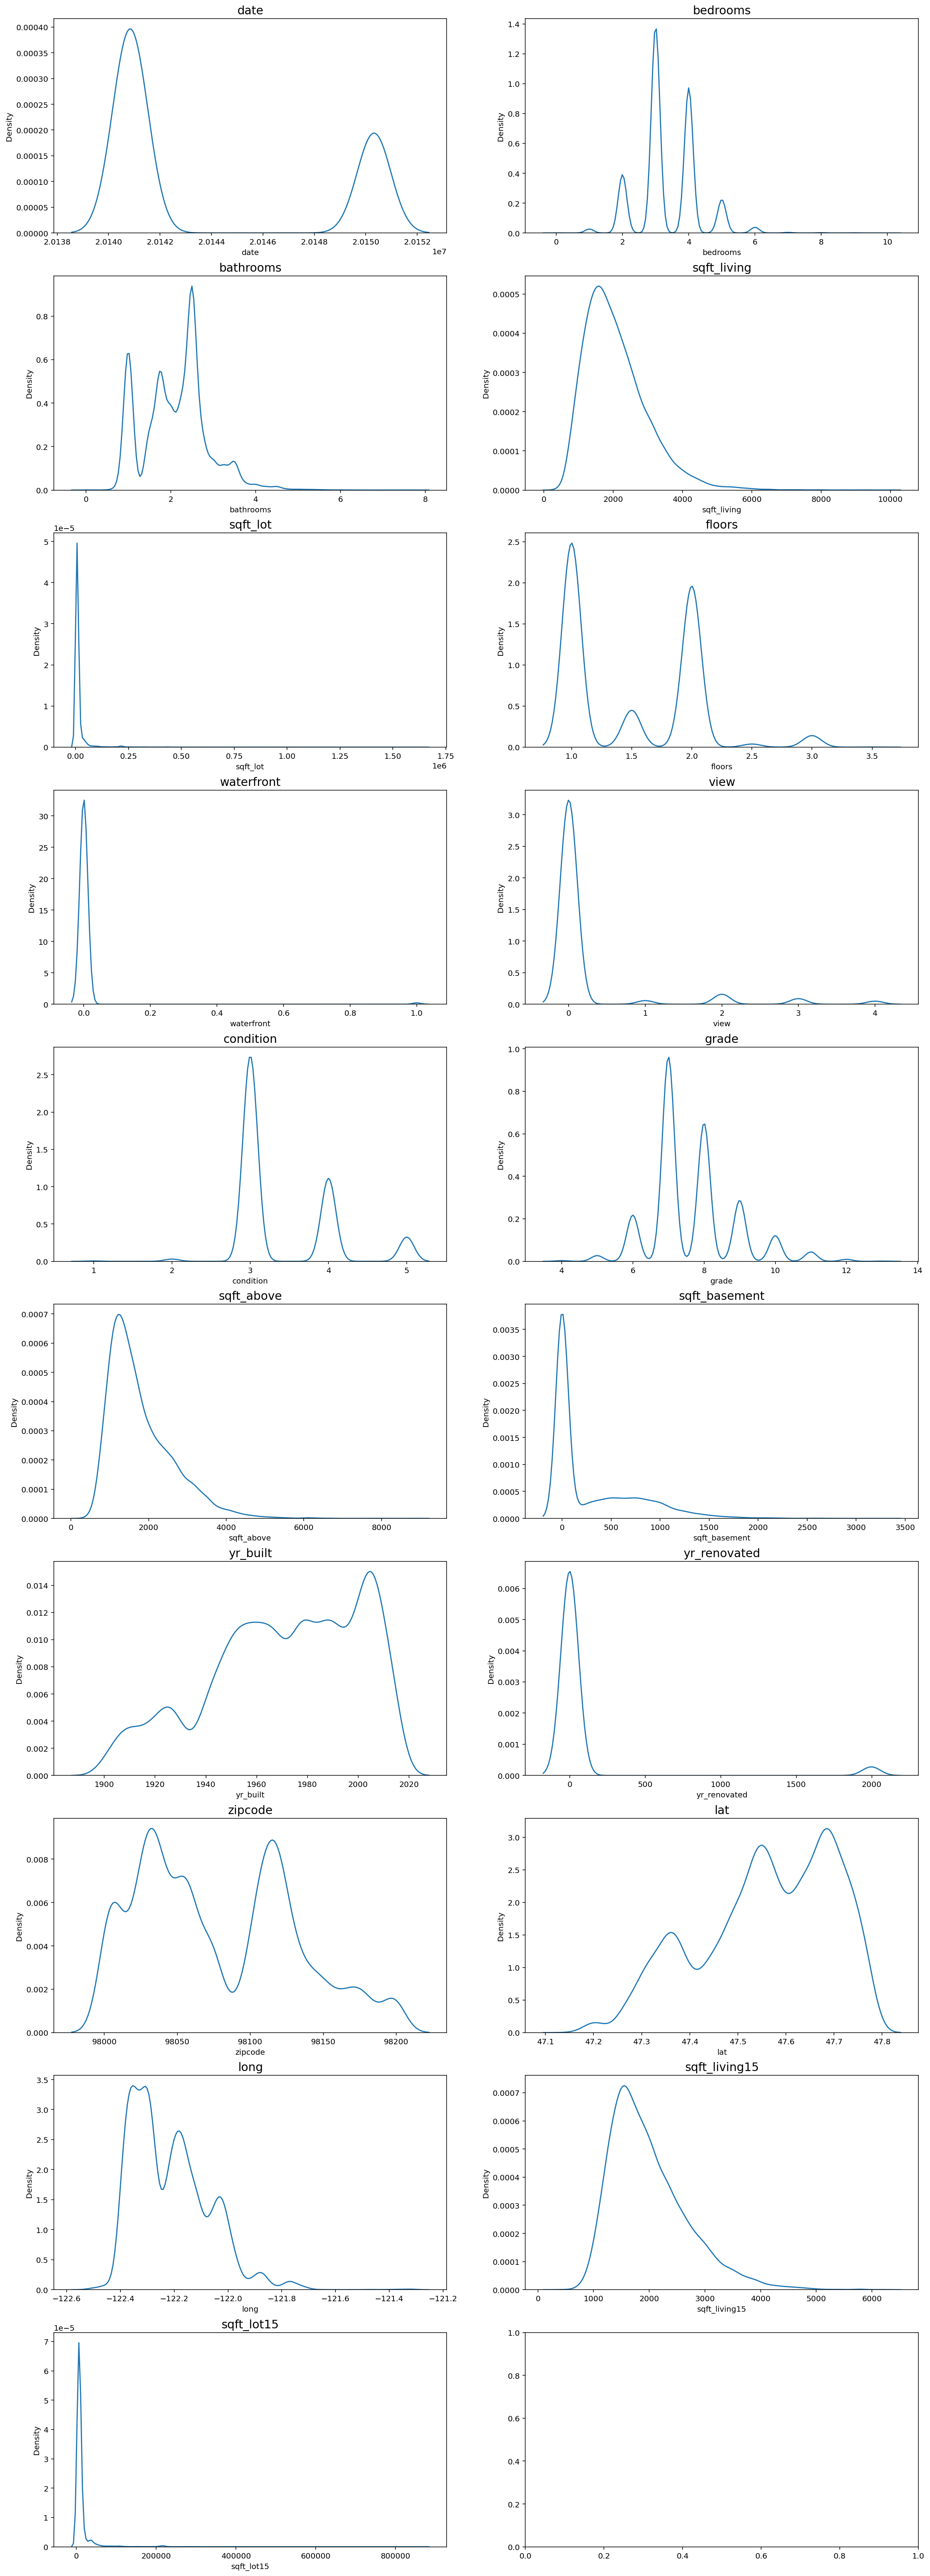

In [36]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# 19개의 지표를 분석합니다.
count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

지표 별로 보니 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15' 들이 한쪽으로 치우쳐져 있습니다.  
이들을 정규화하겠습니다.

In [37]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15']

for col in skew_columns:
    train[col] = np.log1p(train[col].values)
    test[col] = np.log1p(test[col].values)

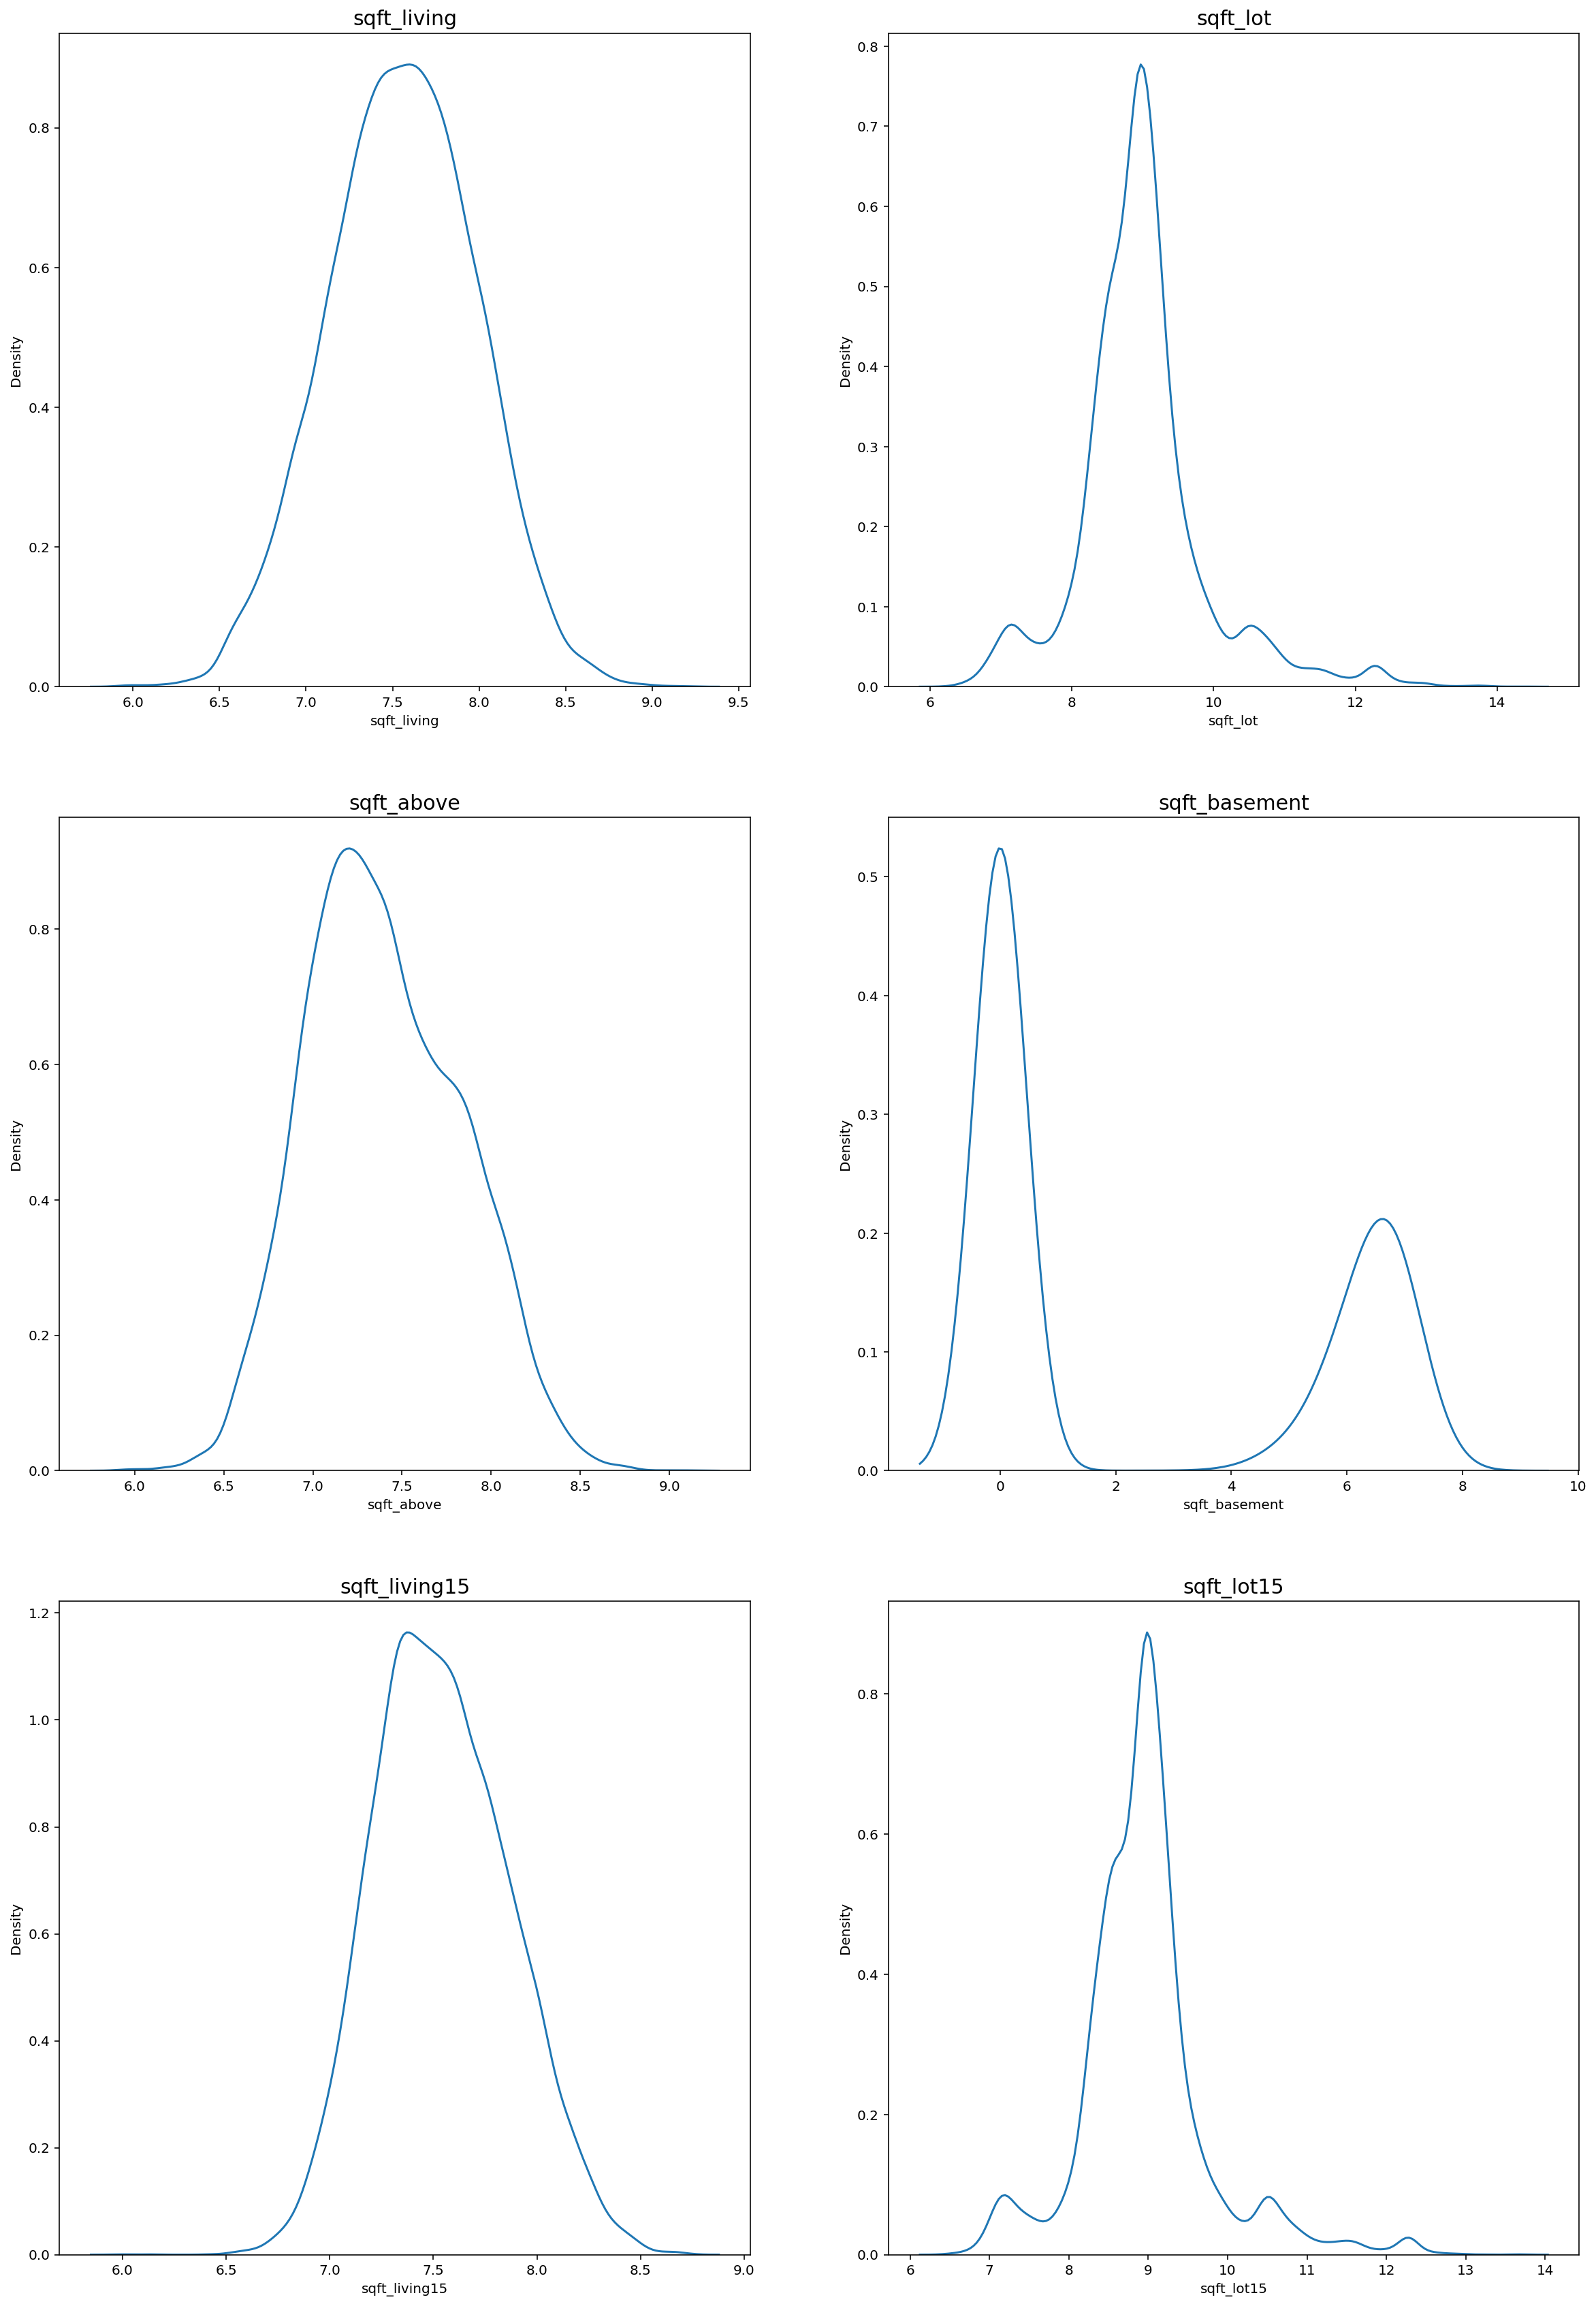

In [38]:
fig, ax = plt.subplots(3, 2, figsize=(20, 30))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1
        if count == 6 :
            break

6개의 지표들이 어느 정도 정규 분포를 따라가게 되었군요.  
추가로 yr_renovated 값이 0이 포함되어 있어 지표로 활용되기 어려울 것 같습니다.  
yr_renovated에서 0인 값은 yr_built값으로 채워 넣어주도록 합시다.  

In [39]:
for df in [train,test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    # 0인 경우 먼저 na 값을 넣어준다
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])
    # na 값이 있으면 yr_built 값으로 채워준다.

In [40]:
train.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141013         3       1.00     7.074117  8.639588     1.0           0   
1  20150225         2       1.00     6.647688  9.210440     1.0           0   
2  20150218         3       2.00     7.427144  8.997271     1.0           0   
3  20140627         3       2.25     7.447751  8.827615     2.0           0   
4  20150115         3       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7    7.074117            0.0      1955        1955.0   
1     0          3      6    6.647688            0.0      1933        1933.0   
2     0          3      8    7.427144            0.0      1987        1987.0   
3     0          3      7    7.447751            0.0      1995        1995.0   
4     0          3      7    6.966967            0.0      1963        1963.0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257       7.201171    8.639588  
1    98028  47.7379 -122.233       7.908755    8.995041  
2    98074  47.6168 -122.045       7.496097    8.923191  
3    98003  47.3097 -122.327       7.713785    8.827615  
4    98198  47.4095 -122.315       7.409136    9.181118

In [41]:
test.head()

date  bedrooms  bathrooms  sqft_living   sqft_lot  floors  waterfront  \
0  20141209         3       2.25     7.852050   8.887791     2.0           0   
1  20141209         4       3.00     7.581210   8.517393     1.0           0   
2  20140512         4       4.50     8.598036  11.532051     1.0           0   
3  20150415         3       1.00     7.484930   8.918784     1.0           0   
4  20150312         3       2.50     7.544861   8.788898     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7    7.682943       5.993961      1951        1991.0   
1     0          5      7    6.957497       6.814543      1965        1965.0   
2     0          3     11    8.266421       7.333676      2001        2001.0   
3     0          3      7    6.957497       6.594413      1960        1960.0   
4     0          3      7    7.544861       0.000000      2003        2003.0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98125  47.7210 -122.319       7.433075    8.941153  
1    98136  47.5208 -122.393       7.215975    8.517393  
2    98053  47.6561 -122.005       8.468213   11.532051  
3    98146  47.5123 -122.337       7.484930    9.001346  
4    98038  47.3684 -122.031       7.779467    8.932080

어느정도 전처리가 끝났습니다.  
다음 단계로 가도록 하겠습니다.

#### 모델 설계

일단 여러가지 Regressor들을 import 합니다.

In [42]:
random_state = 2022
# 돌릴 때 마다 같은 값 나오도록
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
exforest = ExtraTreesRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest, exforest]

일단 아무 파라미터 변경없이 random_state만 값을 줍니다.

In [43]:
def get_scores(models, train, y):
    df ={}
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

# get_scores(models, train, y)

LGBM - XGB - EXTree - Gradient - RanTree 순으로 RMSE가 낮습니다.  
그럼 일단 모델은 LGBM을 써보도록 합시다.  
LGBM의 하이퍼 파라미터 튜닝을 위해 그리드 탐색을 사용해봅시다.  
단, GridSearch를 통해 나오는 metric은 log된 y로 계산되므로  
RMSE 대신 RMSLE

In [44]:
from sklearn.model_selection import GridSearchCV


def my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose = verbose, n_jobs = n_jobs)
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    df_grid = pd.DataFrame(params)
    df_grid['score'] = score
    df_grid['RMSLE'] = np.sqrt(-1 * df_grid['score'])
    df_grid = df_grid.sort_values('RMSLE')
    
    df_grid = df_grid.head()
    return df_grid

여러 파라미터를 두고 범위를 줍니다.  
Default값과 관련해서는 [링크](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)를 참조하였습니다.  
계속해서 파라미터 범위를 변경해가면서 최적의 파라미터를 찾은뒤 마지막에 default 값과 비교하여 출력합니다.

In [45]:
param_grid = {
    # 'max_depth': [10,15,20,25,30],           # -1 : no limit
    'max_depth': [10,15],                      # -1 : no limit
    
    'num_leaves' : [20,31],
    # 'learning_rate' : [0.07,0.08,0.09,0.1],     # 0.1
    # 'learning_rate' : [0.08],                   # 0.1
    'learning_rate' : [0.1,0.08],                # 0.1
    
    # 'n_estimators': [100, 200, 300],          # 100
    # 'n_estimators': [200, 300, 400],          # 100
    # 'n_estimators': [300, 350, 400],          # 100
    'n_estimators': [300, 500],                 # 100
    
    # 'boosting_type' : ['gbdt','dart','goss'],     # gbdt (str)
    # boostinrg_type은 다른 파라미터를 변경해도 gbdt가 더 높게 나와서 계산시간상 생략하겠습니다.
    
    # 'subsample' : [0.7],                        # 1.0
    # 'colsample_bytree' :  [0.7],                # 1.0
    'min_child_samples' : [30,50,80],               # 20
    # 'reg_lambda' : [1.1]                      # 0
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=0, n_jobs=5)

learning_rate  max_depth  min_child_samples  n_estimators  num_leaves  \
16           0.10         15                 50           300          20   
18           0.10         15                 50           500          20   
42           0.08         15                 50           500          20   
30           0.08         10                 50           500          20   
4            0.10         10                 50           300          20   

       score     RMSLE  
16 -0.025421  0.159440  
18 -0.025430  0.159467  
42 -0.025469  0.159590  
30 -0.025544  0.159826  
4  -0.025565  0.159892

learning_rate = 0.1, max_depth = 15, min_child_samples = 50, n_estimators = 300, num_leaves = 20

점수를 더 올리기 위해 Average Blending을 사용해봅시다.  
모델은 LGBM, XGB, ExtraTree를 사용해보겠습니다.  
LGBM은 이미 구한 파라미터를 사용하겠습니다.  
XGB와 ExtraTree을 사용하기 위한 적절한 파라미터 분석을 해보겠습니다.

In [46]:
model2 = XGBRegressor(random_state=random_state)

param_grid = {
    # 'max_depth' : [2,4,6],
    'max_depth' : [4,5,6],
    'eta' : [0.1,0.3],
    'subsample' : [0,1],
    # 'reg_lambda' : [0,1],  
    # 'reg_alpha' : [0,1]    
}

my_GridSearch(model2, train, y, param_grid, verbose=0, n_jobs=5)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resource

eta  max_depth  subsample     score     RMSLE
5   0.1          6          1 -0.027314  0.165269
7   0.3          4          1 -0.028078  0.167564
9   0.3          5          1 -0.028277  0.168159
11  0.3          6          1 -0.028341  0.168349
3   0.1          5          1 -0.028358  0.168397

* eta = 0.1, max_depth = 6, subsample = 1  
를 사용하겠습니다.

In [47]:
model3 = ExtraTreesRegressor(random_state=random_state)

param_grid = {
        'max_features': [100,150],
        
        'min_samples_leaf': [1,5],
        
        'min_samples_split': [3,5],
        
        'n_estimators': [100,300],        
}

my_GridSearch(model3, train, y, param_grid, verbose=0, n_jobs=5)

max_features  min_samples_leaf  min_samples_split  n_estimators     score  \
3            100                 1                  5           300 -0.029880   
11           150                 1                  5           300 -0.029880   
1            100                 1                  3           300 -0.029947   
9            150                 1                  3           300 -0.029947   
2            100                 1                  5           100 -0.030075   

       RMSLE  
3   0.172859  
11  0.172859  
1   0.173053  
9   0.173053  
2   0.173423

* max_features = 100, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300  
를 사용하겠습니다.

3가지 모델을 사용해서 AverageBlending을 해봅시다.

In [48]:
# learning_rate = 0.1, max_depth = 15, min_child_samples = 50, n_estimators = 300, num_leaves = 20
model1 = LGBMRegressor(learning_rate = 0.1, max_depth = 15, min_child_samples = 50, n_estimators = 300, num_leaves = 20, random_state=random_state)
# eta = 0.1, max_depth = 6, subsample = 1
model2 = XGBRegressor(eta = 0.1, max_depth = 6, subsample = 1 , random_state=random_state)
# max_features = 100, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300
model3 = ExtraTreesRegressor(max_features = 100, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300, random_state=random_state)



models = [{'model':model1, 'name':'LGBMR'}, {'model':model2, 'name':'XGBR'},
          {'model':model3, 'name':'ExtraTreeR'}]


def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred = np.expm1(y_pred)

6468


In [49]:
data_dir = os.getenv('HOME')+'/Code/Exploration Submit/3/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.shape
submission['price'] = y_pred
submission_csv_path = '{}/submission_AveragingBlending.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)


### 회고

* 이번 프로젝트에서 어려웠던 점
    - 전체적으로?
    - Preprocessing의 접근 방향을 잘 몰라서 다른 코드를 참고했어야했습니다.
    - GridSearch의 사용방법을 알았지만 각 지표별로 범위를 어떻게 잡아야할지 감이 오지않아 점수를 낮추기가 어려웠습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된점
    - 이상치 제거는 그래프를 그려서 제거할 수 있다.
    - 데이터프레임에 특정 기준으로 새로운 값을 넣고 싶을때 na 값으로 바꾸고 na 채우는 함수를 사용하며 편하다.
    - 여러 모델들의 지표들의 내용(반복, Overfitting 제어, max_depth 등등)
  * 아직 모호한 점
    - GridSearch에 들어가는 지표들의 범위값, 주로 참고해야할 지표, 어떤 다른 방식으로 모델을 조합하면 되는가?
* 루브릭 평가를 맞추기 위해 시도한 점
    - 그래프를 그려가면서 preprocessing을 진행하였다.
    - score를 낮추기 위해 여러가지 지표들을 사용해보았다.(결국 최종적으로 112587.47324이 최솟값이였습니다.ㅠ)